In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import seaborn as sns
from pyDOE import lhs
import random
import os
import time

plt.rcParams.update({'font.size':18})

In [3]:
def seed_torch(seed=1024):
#     random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
#     torch.use_deterministic_algorithms(True)  # 有检查操作，看下文区别
 
seed_torch(314)

In [4]:
domain = (0, 20, -20, 20)
tmin, tmax, xmin, xmax = domain
backbone_layers = [2] + [40]*3 + [2]
adam_iters = 5000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = r'./model'
train_info_path = r'./'
if not os.path.exists(model_path):
    os.mkdir(model_path)

In [5]:
class DatasetBurgers:
    def __init__(self, domain):
        self.domain = domain
    
    def train_data(self, verbose=None):
        tmin, tmax, xmin, xmax = self.domain
        # 内部点采样
        t_res = np.linspace(tmin, tmax, 100)
        x_res = np.linspace(xmin, xmax, 100)
        X_res = self.sample_xy(t_res, x_res)
        # 真实数据
        X_data,u_data = self.added_data(X_res)
        
        return X_res, X_data, u_data
    
    def sample_xy(self, x, y):
        xx, yy = np.meshgrid(x, y)
        X = np.concatenate([xx.reshape((-1, 1)), yy.reshape((-1, 1))], axis=1)
        return X
    
    def added_data(self,X_res):
        u_data = 4 * np.arctan(np.sin(X_res[:,0]/math.sqrt(2))/np.cosh(X_res[:,1]/math.sqrt(2)))
        u_data = u_data.reshape(-1, 1)
        
        # 随机采样一小批数据 用以反演
        idx = np.random.permutation(range(u_data.shape[0]))
        idx = idx[:2000]  # 采样2000个真实数据点
        return X_res[idx,:],u_data[idx,:]
    

dataset = DatasetBurgers(domain)
X_res, X_data, u_data = dataset.train_data()
print(X_res.shape, X_data.shape,u_data.shape)

(10000, 2) (2000, 2) (2000, 1)


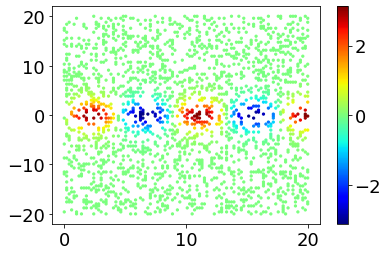

In [6]:
plt.scatter(X_data[:, 0], X_data[:, 1], c=u_data[:, 0], s=5, cmap='jet')
plt.colorbar()

In [7]:
class MLP(nn.Module):
    def __init__(self, mlp_layers):
        super(MLP, self).__init__()
        
        self.model = nn.Sequential()
        for i in range(len(mlp_layers)-2):
            layer = nn.Sequential()
            layer.add_module(f'fc{i}', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            layer.add_module(f'act{i}', nn.Tanh())
            self.model.add_module(f'layer{i}', layer)

        last_layer = nn.Sequential()
        last_layer.add_module(f'fc{len(mlp_layers)-2}', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
        self.model.add_module(f'layer{len(mlp_layers)-2}', last_layer)
        
#         for param in self.parameters():
#             if len(param.shape) > 1:
#                 nn.init.kaiming_normal_(param)
    
    def forward(self, X):
        return self.model(X)
    
backbone = MLP(backbone_layers)

In [8]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True, 
                               retain_graph=True)

In [9]:
class PINNBurgers(nn.Module):
    def __init__(self, backbone, mu=None, sigma=None):
        super(PINNBurgers, self).__init__()
        self.backbone = backbone
        self.lam1 = torch.tensor([2.0], requires_grad=True)     
        self.lam1 = torch.nn.Parameter(self.lam1)

        if mu is not None and sigma is not None:
            self.is_inputs_normalization = True
            self.mu = mu
            self.sigma = sigma
            print(f'forward with normalization, mu={self.mu.tolist()}, sigma={self.sigma.tolist()}')
        else:
            self.is_inputs_normalization = False
    
    def forward(self, X_res, X_data, u_data):
        loss_res = torch.mean(self.net_f(X_res)**2)
        loss_data = torch.mean(self.net_data(X_data, u_data)**2)
        return loss_res, loss_data
    
    def net_u(self, X):
        if self.is_inputs_normalization == True:
            X = (X - self.mu) / self.sigma
        return self.backbone(X)
    
    def net_f(self, X_res):
        X_res.requires_grad_(True)
        phi = self.net_u(X_res)
        u = phi[:,0]
        lam1 = phi[:,1]

        grad_u = grad(u, X_res)[0]
        u_t = grad_u[:,[0]]
        u_x = grad_u[:,[1]]
        u_tt = grad(u_t, X_res)[0][:,[0]]
        u_xx = grad(u_x, X_res)[0][:,[1]]
        
        u=u.detach().numpy()
        sin_u = torch.tensor(np.sin(u))
        
        f = u_tt - lam1* u_xx + sin_u
        return f
  
    def net_data(self, X_data, u_data):
        u_data_pred = self.net_u(X_data)
        data = u_data_pred - u_data
        return data
    

pinn = PINNBurgers(backbone)

In [10]:
dataset = DatasetBurgers(domain)  # 生成训练数据
X_res, X_data, u_data = dataset.train_data()
X_res = torch.from_numpy(X_res).float().to(device)
X_data = torch.from_numpy(X_data).float().to(device)
u_data = torch.from_numpy(u_data).float().to(device)


mu = X_res.mean(dim=0)
sigma = X_res.std(dim=0)  # 求样本标准差

backbone = MLP(backbone_layers)  # 主干网络
pinn = PINNBurgers(backbone, mu, sigma).to(device)

optimizer_adam = optim.Adam(pinn.backbone.parameters(), lr=1e-3)

lr_sche = optim.lr_scheduler.ExponentialLR(optimizer_adam, gamma=0.8)  # 指数衰减学习率

logger = {
    "loss": [], 
    "loss_res": [],
    "loss_data": [],
    "iter": [],
    "mu": mu,
    "sigma": sigma
}
best_loss = 1e9

# 训练
start_time = time.time()
for it in range(adam_iters):
    pinn.train()
    pinn.zero_grad()
    
    loss_res, loss_data = pinn(X_res, X_data, u_data)
    loss = loss_res + loss_data
    
    loss.backward()
    optimizer_adam.step()
    
    if (it + 1) % 100 == 0:
        # 保存loss信息
        pinn.train(False)
        loss_res_valid, loss_data_valid = pinn(X_res, X_data, u_data)
        loss_valid = loss_res_valid + loss_data_valid
        
        logger["loss"].append(loss_valid.item())
        logger["loss_res"].append(loss_res_valid.item())
        logger["loss_data"].append(loss_data_valid.item())
        logger["iter"].append(it+1)
        
        
        # 保存训练loss最低的模型
        if loss_valid.item() < best_loss:
            model_state = {'iter': it+1, 'backbone_state': pinn.backbone.state_dict()}
            torch.save(model_state, os.path.join(model_path, 'pinn_adam.pth'))
            best_loss = loss_valid.item()
        
        if (it + 1) % 500 == 0:
            # 保存并打印训练日志
            info = f'Iter # {it+1:6d}/{adam_iters}\t' + \
                f'loss:{loss.item():.2e}, loss_r:{loss_res.item():.2e}, loss_d:{loss_data.item():.2e}  ' + \
                f'Valid # loss:{loss_valid.item():.2e}, loss_r:{loss_res_valid.item():.2e}, loss_d:{loss_data_valid.item():.2e}'
            with open(train_info_path + 'train_info.txt', 'a') as f:
                f.write(info + '\n')
            print(info)
            
        # 衰减学习率
        if (it + 1) % 4000 == 0:
            lr_sche.step()

forward with normalization, mu=[10.0, -9.765624753299562e-08], sigma=[5.831820964813232, 11.663641929626465]
Iter #    500/5000	loss:1.63e-01, loss_r:1.37e-01, loss_d:2.58e-02  Valid # loss:1.63e-01, loss_r:1.37e-01, loss_d:2.56e-02
Iter #   1000/5000	loss:1.61e-01, loss_r:1.37e-01, loss_d:2.44e-02  Valid # loss:1.61e-01, loss_r:1.37e-01, loss_d:2.43e-02
Iter #   1500/5000	loss:1.59e-01, loss_r:1.35e-01, loss_d:2.40e-02  Valid # loss:1.59e-01, loss_r:1.35e-01, loss_d:2.40e-02
Iter #   2000/5000	loss:1.59e-01, loss_r:1.35e-01, loss_d:2.38e-02  Valid # loss:1.59e-01, loss_r:1.35e-01, loss_d:2.38e-02
Iter #   2500/5000	loss:1.58e-01, loss_r:1.35e-01, loss_d:2.36e-02  Valid # loss:1.58e-01, loss_r:1.35e-01, loss_d:2.36e-02
Iter #   3000/5000	loss:1.58e-01, loss_r:1.35e-01, loss_d:2.35e-02  Valid # loss:1.58e-01, loss_r:1.35e-01, loss_d:2.36e-02
Iter #   3500/5000	loss:1.58e-01, loss_r:1.35e-01, loss_d:2.35e-02  Valid # loss:1.58e-01, loss_r:1.35e-01, loss_d:2.35e-02
Iter #   4000/5000	loss

In [11]:
np.save("./logger.npy", logger)
model_state

{'iter': 5000,
 'backbone_state': OrderedDict([('model.layer0.fc0.weight',
               tensor([[-0.2746, -0.7432],
                       [ 0.2519,  0.6821],
                       [ 0.5386, -0.0788],
                       [ 0.3535, -1.1823],
                       [-0.1011,  1.0630],
                       [ 0.8657, -0.7201],
                       [ 0.3236, -0.1108],
                       [-0.5657, -0.9064],
                       [-0.8027, -0.0099],
                       [-0.7028, -0.0768],
                       [ 0.7347, -0.8569],
                       [-0.4703, -0.6332],
                       [ 0.5628, -0.6375],
                       [ 0.4332,  0.3116],
                       [-0.7668,  0.2235],
                       [-0.5623, -0.3737],
                       [ 0.8148, -0.3429],
                       [ 0.0729, -1.1199],
                       [-0.2754,  0.6930],
                       [-0.7755, -1.0472],
                       [-0.5915,  0.7749],
                      

In [12]:
mu = X_res.mean(dim=0)
sigma = X_res.std(dim=0)

backbone = MLP(backbone_layers)  # 主干网络
pinn = PINNBurgers(backbone, mu, sigma)

model_state = torch.load(os.path.join(model_path, 'pinn_adam.pth'))
pinn.backbone.load_state_dict(model_state['backbone_state'])

pinn.eval()

# 导入数据
tmin, tmax, xmin, xmax = domain
# 内部点采样
t = np.linspace(tmin, tmax, 100)
x = np.linspace(xmin, xmax, 100)

# 生成网格
TT, XX = np.meshgrid(t, x)
TX = np.concatenate([TT.reshape(-1,1), XX.reshape(-1,1)], axis=1)
TX = torch.from_numpy(TX).float()
TX = TX.to(torch.float64)

# true
u_star = 4 * np.arctan(np.sin(TT/math.sqrt(2))/np.cosh(XX/math.sqrt(2)))

# pred
pinn = pinn.cpu().double()
phi = pinn.net_u(TX).detach().numpy()
u_pred = phi[:,0]
lam_pred = phi[:,1]
u_pred = u_pred.reshape(TT.shape)

u_error = np.linalg.norm(u_pred - u_star) / np.linalg.norm(u_star) 
print('Relative l2 error of u: {:.3e}'.format(u_error))
print(u_star.shape)
print(u_pred.shape)


forward with normalization, mu=[10.0, -9.765624753299562e-08], sigma=[5.831820964813232, 11.663641929626465]
Relative l2 error of u: 3.565e-01
(100, 100)
(100, 100)


In [16]:
lam1_star = 1

lam_pred = np.mean(lam_pred)
print('lam1_pred:',lam_pred)


# lam1_pred = lam1_pred.detach().numpy()
# lam1_pred = lam1_pred.reshape(t.shape)
lam1_error = np.linalg.norm(lam_pred - lam1_star) / np.linalg.norm(lam1_star)

print('Relative l2 error of lam1: {:.3e}'.format(lam1_error))

lam1_pred: 0.04750842971622094
Relative l2 error of lam1: 9.525e-01


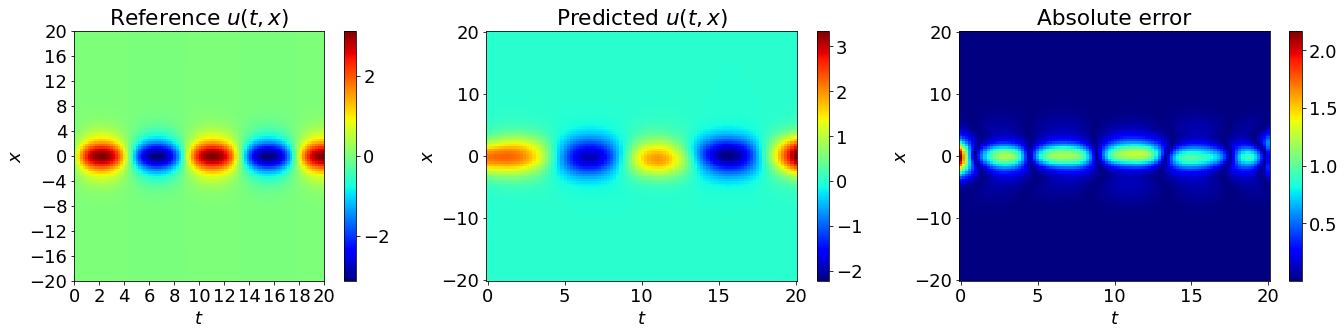

In [17]:
fig = plt.figure(figsize=(20, 5))
axes = fig.subplots(1, 3)

plt.subplot(1,3,1)
# cax1 = axes[0].pcolor(TT, XX, u_star, cmap='jet')
cax1 = plt.pcolor(TT, XX, u_star, cmap='jet')
fig.colorbar(cax1)
axes[0].set_xlabel('$t$')
axes[0].set_ylabel('$x$')
axes[0].set_title(r'Reference $u(t,x)$')
axes[0].set_xlim([0, 20])
axes[0].set_ylim([-20, 20])
axes[0].set_xticks(np.arange(0, 20.1, 2.))
axes[0].set_yticks(np.arange(-20, 20.1, 4.))
axes[0].set_aspect(1./axes[0].get_data_ratio())

plt.subplot(1,3,2)
cax2 = plt.pcolor(TT, XX, u_pred, cmap='jet')
fig.colorbar(cax2)
axes[1].set_xlabel('$t$')
axes[1].set_ylabel('$x$')
axes[1].set_title(r'Predicted $u(t,x)$')
axes[0].set_xlim([0, 20])
axes[0].set_ylim([-20, 20])
axes[0].set_xticks(np.arange(0, 20.1, 2.))
axes[0].set_yticks(np.arange(-20, 20.1, 4.))
axes[0].set_aspect(1./axes[0].get_data_ratio())

plt.subplot(1,3,3)
cax3 = plt.pcolor(TT, XX, np.abs(u_star - u_pred), cmap='jet')
fig.colorbar(cax3)
axes[2].set_xlabel('$t$')
axes[2].set_ylabel('$x$')
axes[2].set_title('Absolute error')
axes[0].set_xlim([0, 20])
axes[0].set_ylim([-20, 20])
axes[0].set_xticks(np.arange(0, 20.1, 2.))
axes[0].set_yticks(np.arange(-20, 20.1, 4.))
axes[0].set_aspect(1./axes[0].get_data_ratio())

plt.tight_layout()
plt.savefig('SG_result.png', dpi=100, bbox_inches='tight')
plt.show()